In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib import pyplot as plt
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = colors.values()

plt.style.use('style.mpl')

# Code generating Figure 6 
Figure 6 describes our model's prediction of correlated protein ZC values within genomes (diagram) and gives evidence for this prediction from GTDB representative genomes. Diagrams are added later in Illustrator. 

In [2]:
# Load the data for the NOSC correlation figure
# Description of the bac120 genes
bac120_meta_df = pd.read_csv('../data/gtdb/r207/bac120_msa_marker_info_r207_annot.csv',
                             index_col=0)

# Amino acid properties -- ZC, hydrophobicity, etc.
aa_nosc_df = pd.read_csv('../data/aa_nosc.csv')

# Read the ZC values for bac120 as a wide-form matrix
# These were generated by running munge/munge_bac120.py
bac120_nosc_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_vals_wide.csv', index_col=0)

# Read the correlation matrix for bac120 -- raw correlations first
# File generated by running munge/calc_bac120_corr.py
nosc_corr_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr.csv', index_col=[0,1])

# Calculate the IQR of the correlations
raw_r_IQR = nosc_corr_df.r.quantile([0.25, 0.75]).values

# Correlations controlled for mean genome NOSC
# File generated by running munge/calc_bac120_corr.py
nosc_corr_controlled_df = pd.read_csv('../data/gtdb/r207/bac120_nosc_corr_controlled_for_genome_nosc.csv', index_col=[0,1])

In [3]:
xs = nosc_corr_df.index.get_level_values(0)
ys = nosc_corr_df.index.get_level_values(1)
bp_len_xs = bac120_meta_df.loc[xs, 'Length (bp)'].values
bp_len_ys = bac120_meta_df.loc[ys, 'Length (bp)'].values
pair_len_bp = bp_len_xs + bp_len_ys
nosc_corr_df['pair_len_bp'] = pair_len_bp

In [4]:
all_nosc_vals = bac120_nosc_df.values.flatten()
all_nosc_vals = all_nosc_vals[~np.isnan(all_nosc_vals)]
all_nosc_vals

array([-0.14816038, -0.22451515, -0.27199764, ..., -0.17278399,
       -0.12612335, -0.21522908])

In [5]:
# Load the output from optimization runs where ZCred and ZCB are both varied
var_ZCB_df = pd.read_csv('../output/linear_optimization/fix_ZCred_ZCB.csv')
# Mask out the values computed without ATP homeostasis
tmp = var_ZCB_df[var_ZCB_df['opt.max_phi_H_set'] == False]

# Make a matrix of the maximum growth rate values for each pair of (ZCred,ZCB)
ZCred_ZCB_lambda_mat = tmp.pivot_table(index='ZCB', columns='ZCred', values='lambda_hr')

# Calculate the argmax -- the ZCB (index) that maximizes growth rate for each ZCred (column)
ZCB_lambda_argmax = ZCred_ZCB_lambda_mat.idxmax(axis=0)


-3.0 2.9999999999999787
LinregressResult(slope=0.9846153846153876, intercept=0.270769230769241, rvalue=0.9922778767136676, pvalue=3.0110295374638287e-12, stderr=0.035529247334746376, intercept_stderr=0.012113858267710801)
0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.4095090511505405 FtsY RadA


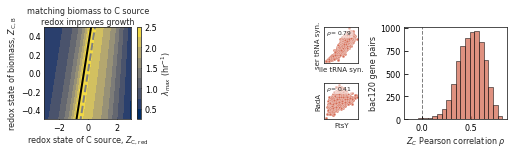

In [6]:
# Make Fig. 6
mosaic = "AABBCEE\nAABBDEE"
fig, axs = plt.subplot_mosaic(mosaic, figsize=(7.24,2.25),
                              gridspec_kw={'width_ratios': [1.1, 1.1, 0.6, 0.6, 1.2, 1, 1]})

# First panel is the contour map of the growth rate as a function of ZCred and ZCB
plt.sca(axs['A'])
plt.contourf(ZCred_ZCB_lambda_mat.columns,
             ZCred_ZCB_lambda_mat.index,
             ZCred_ZCB_lambda_mat.values,
             cmap='cividis')
cbar = plt.colorbar(label='$\lambda_{max}$ (hr$^{-1}$)')
# fewer colorbar ticks
cbar.set_ticks(np.arange(0.5, 2.51, 0.5))

# Plot the argmax values as a line by regressing the argmax values against the ZCred values
min_ZCred = ZCB_lambda_argmax.index.min()
max_ZCred = ZCB_lambda_argmax.index.max()
min_ZCB = ZCB_lambda_argmax.min()
max_ZCB = ZCB_lambda_argmax.max()
print(min_ZCred, max_ZCred)
eps = 0.1
mask = np.logical_and(ZCB_lambda_argmax > min_ZCB + eps, 
                      ZCB_lambda_argmax < max_ZCB - eps)
masked = ZCB_lambda_argmax[mask]
reg_res = linregress(masked.index, masked.values)
print(reg_res)
xs = np.arange(min_ZCred, max_ZCred, 0.01)
ys = xs * reg_res.slope + reg_res.intercept
plt.plot(xs, ys, color='k', lw=2)

# plot the line of equal ZCred and ZCB
plt.plot([min_ZCred, max_ZCred], [min_ZCred, max_ZCred], ls='--', color='grey')

# Set plot bounds
plt.ylim(min_ZCB, max_ZCB)

plt.xlabel('redox state of C source, $Z_{\mathrm{C,red}}$')
plt.ylabel('redox state of biomass, $Z_{\mathrm{C,B}}$')
plt.title('matching biomass to C source\nredox improves growth')

plt.sca(axs['B'])
# clear the axis
plt.axis('off')

pairs = ["TIGR00392,TIGR00414".split(','), "TIGR00064,TIGR00416".split(','), ]
pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
}
greys = sns.color_palette('Greys', n_colors=5)
my_axs = [axs['C'], axs['D']]
for ax, gene_ids in zip(my_axs, pairs):
    plt.sca(ax)

    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1], s=8, color=colors['red'],
                    edgecolor='w', linewidth=0.25)

    desc0 = pnames_dict[gene_ids[0]]
    desc1 = pnames_dict[gene_ids[1]]
    label_fmt = '{0}'
    plt.xlabel(label_fmt.format(desc0), labelpad=3, fontsize=7)
    plt.ylabel(label_fmt.format(desc1), labelpad=3, fontsize=7)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.05, 0.8, '$\\rho = {0:.2g}$'.format(corr), transform=plt.gca().transAxes,
             ha='left', fontsize=6, bbox=dict(facecolor='w', edgecolor='w', lw=0.5, alpha=0.5, pad=0))
    plt.xticks([])
    plt.yticks([])
    plt.tick_params(axis='both', which='both', length=0, pad=0)

plt.sca(axs['E'])

plt.axvline(0, color='grey', lw=1, ls='--', zorder=-1)
# Control in SI figure below. 
sns.histplot(data=nosc_corr_df.r, bins=20, color=colors['red'], edgecolor='k', linewidth=0.5, label='raw')
plt.xlabel('$Z_C$ Pearson correlation $\\rho$')
plt.ylabel('bac120 gene pairs')

plt.tight_layout()
plt.savefig('../output/Fig6_row.pdf', facecolor='w', dpi=300, bbox_inches='tight')
plt.savefig('../output/Fig6_row.png', facecolor='w', dpi=300, bbox_inches='tight')

plt.show()

In [7]:
# Load the output from optimization runs where ZCred and ZCB are both varied
var_ZCB_df = pd.read_csv('../output/linear_optimization/fix_ZCred_ZCB_max_C_uptake.csv')
# Mask out the values computed without ATP homeostasis
tmp = var_ZCB_df[var_ZCB_df['opt.max_phi_H_set'] == False]

# Make a matrix of the maximum growth rate values for each pair of (ZCred,ZCB)
index_cols = 'ZCred,opt.max_C_uptake'.split(',')
ZCred_ZCB_lambda_mat_max_Cup = tmp.pivot_table(index=index_cols, columns='ZCB', values='lambda_hr')

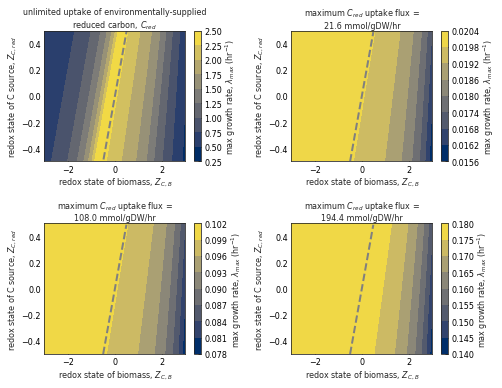

In [8]:
# Potential supplementary figure showing the effect of C-limitation
# which removes the selection pressure for matching ZCred and ZCB
# This motivates a discussion of selection for growth in feast/famine dynamics.
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(7.08,5.5))
flat_axs = axs.flatten()
max_Cups = ZCred_ZCB_lambda_mat_max_Cup.index.levels[1].unique()
vmin, vmax = ZCred_ZCB_lambda_mat_max_Cup.min().min(), ZCred_ZCB_lambda_mat_max_Cup.max().max()

for i, max_Cup in enumerate(max_Cups):
    plt.sca(flat_axs[i+1])

    # get the positions where the second index level (max C uptake) equals 3e-05
    idx = pd.IndexSlice
    tmp_mat = ZCred_ZCB_lambda_mat_max_Cup.loc[idx[:,max_Cup],:]
    plt.contourf(tmp_mat.index.levels[0],
                 tmp_mat.columns,
                 tmp_mat.values.T,
                 cmap='cividis')

    xs = np.arange(ZCred_ZCB_lambda_mat_max_Cup.columns.min(), ZCred_ZCB_lambda_mat_max_Cup.columns.max(), 0.01)
    plt.plot(xs, xs, ls='--', color='grey')
    plt.xlabel('redox state of biomass, $Z_{C,B}$')
    plt.ylabel('redox state of C source, $Z_{C,red}$')
    # max_Cup is in units of mol C/gC/s --> convert to mmol C/gDW/hr
    max_Cup_mmol_g_hr = max_Cup * 3600 * 1000
    plt.title('maximum $C_{{red}}$ uptake flux =\n{:.1f} mmol/gDW/hr'.format(
        max_Cup_mmol_g_hr))

    plt.colorbar(label='max growth rate, $\lambda_{max}$ (hr$^{-1}$)')

plt.sca(flat_axs[0])
plt.contourf(ZCred_ZCB_lambda_mat.columns,
             ZCred_ZCB_lambda_mat.index,
             ZCred_ZCB_lambda_mat.values,
             cmap='cividis')
plt.colorbar(label='max growth rate, $\lambda_{max}$ (hr$^{-1}$)')

xs = np.arange(ZCred_ZCB_lambda_mat.columns.min(), ZCred_ZCB_lambda_mat.columns.max(), 0.01)
plt.plot(xs, xs, ls='--', color='grey')
plt.xlabel('redox state of biomass, $Z_{C,B}$')
plt.ylabel('redox state of C source, $Z_{C,red}$')
plt.title('unlimited uptake of environmentally-supplied\nreduced carbon, $C_{red}}$')
# Set plot bounds
plt.ylim(min_ZCB, max_ZCB)

plt.tight_layout()
plt.savefig('../output/FigSX_Climitation.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

0.8000155057409526 RecG DNA primase
0.7932624352511349 ile tRNA syn. ser tRNA syn.
0.6499922476385853 Era RecG
0.5398362792149818 YqgF RecR
0.4095090511505405 FtsY RadA
0.2022310253031126 ribosomal protein uL15 PPAT
0.1198584950885396 SecG ribosomal protein uL13
0.0175372666307355 SecG RecA
-0.0584155890966763 SecG RNA pol $\beta$ subunit


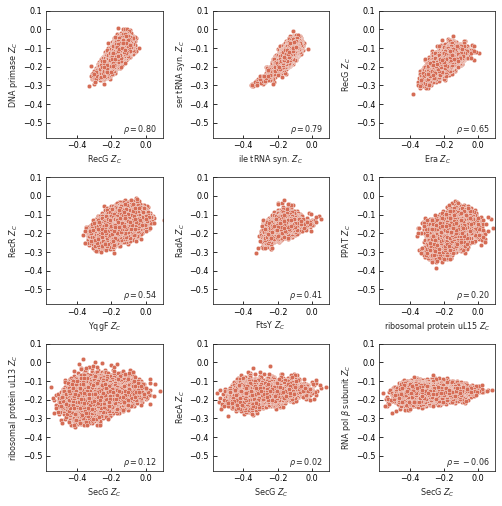

In [9]:
# SI Figure showing a gallery of correlations between ZC values
# Same as middle pannel above, but larger, with more examples and with ticks
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7.08, 7.08))
pairs = ["TIGR00643,TIGR01391".split(','), "TIGR00392,TIGR00414".split(','), "TIGR00436,TIGR00643".split(','),
         "TIGR00250,TIGR00615".split(','), "TIGR00064,TIGR00416".split(','), "TIGR01071,TIGR01510".split(','),
         "TIGR00810,TIGR01066".split(','), "TIGR00810,TIGR02012".split(','), "TIGR00810,TIGR02386".split(',')]

pnames_dict = {
    'TIGR00392': 'ile tRNA syn.',
    'TIGR00414': 'ser tRNA syn.',
    'TIGR00810': 'SecG',
    'TIGR02012': 'RecA',
    'TIGR00064': 'FtsY',
    'TIGR00416': 'RadA',
    'TIGR01071': 'RplO',
    'TIGR01510': 'PPAT',  # pantetheine-phosphate adenylyltransferase
    'TIGR00643': 'RecG',
    'TIGR01391': 'DNA primase',
    'TIGR00436': 'Era',
    'TIGR00250': 'YqgF',
    'TIGR00615': 'RecR',
    'TIGR01071': 'ribosomal protein uL15',
    'TIGR01066': 'ribosomal protein uL13',
    'TIGR02386': 'RNA pol $\\beta$ subunit',
}
greys = sns.color_palette('Greys', n_colors=5)
for ax, gene_ids in zip(axs.flatten(), pairs):
    plt.sca(ax)
    sns.scatterplot(data=bac120_nosc_df, x=gene_ids[0], y=gene_ids[1],
                    s=20, color=colors['red'], edgecolor='w')

    desc0 = pnames_dict.get(gene_ids[0], 'gene')
    desc1 = pnames_dict.get(gene_ids[1], 'gene')
    label_fmt = '{0} $Z_C$'
    plt.xlabel(label_fmt.format(desc0), labelpad=3)
    plt.ylabel(label_fmt.format(desc1), labelpad=3)

    corr = nosc_corr_df.loc[gene_ids[0], gene_ids[1]].r
    print(corr, desc0, desc1)
    plt.text(0.95, 0.05, '$\\rho = {0:.2f}$'.format(corr), transform=plt.gca().transAxes, ha='right', fontsize=8)
    #plt.tick_params(axis='both', which='both', length=0, pad=0)
    plt.xlim(-0.58, 0.1)
    plt.ylim(-0.58, 0.1)
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()
plt.savefig('../output/FigSX_ZC_corr_gallery.png', facecolor='w', dpi=300,  bbox_inches='tight')
plt.show()

-0.15778975575545168 0.05524694077902046


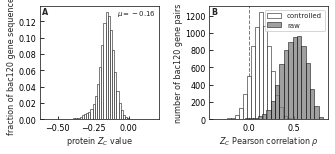

In [10]:
# SI figure showing the distribution of ZC values and the correlation values
# for the controlled and raw correlations
fig, axs = plt.subplots(ncols=2, figsize=(4.76, 2.25))

plt.sca(axs[0])
sns.histplot(data=all_nosc_vals, bins=50, color='w', edgecolor='k', linewidth=0.5, alpha=1.0, stat='proportion')
plt.xlabel('protein $Z_C$ value')
plt.ylabel('fraction of bac120 gene sequences')
mean = np.mean(all_nosc_vals)
std = np.std(all_nosc_vals)
plt.text(0.98, 0.98, '$\\mu = {0:.2f}$'.format(mean),
         transform=plt.gca().transAxes, ha='right', va='top', fontsize=7)
print(mean, std)

plt.sca(axs[1])
plt.axvline(0, color='grey', lw=1, ls='--', zorder=-1)
sns.histplot(data=nosc_corr_controlled_df.r, bins=20, color='w', edgecolor='k', linewidth=0.5, label='controlled', alpha=1.0)
sns.histplot(data=nosc_corr_df.r, bins=20, color='grey', edgecolor='k', linewidth=0.5, label='raw')
plt.xlabel('$Z_C$ Pearson correlation $\\rho$')
plt.ylabel('number of bac120 gene pairs')
plt.legend(loc=1)

panel_labels = 'AB'
for ax, label in zip(axs, panel_labels):
    plt.sca(ax)
    plt.text(0.02, 0.99, label, transform=plt.gca().transAxes, fontsize=8,
             va='top', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_controlled_corr.png', dpi=300, facecolor='w')
plt.show()

In [11]:
# calculate the interval including the middle 99% of correlations
np.quantile(nosc_corr_df.r, [0.005, 0.995])

array([0.07737205, 0.76697797])

[-0.13450239 -0.21431808] [0.03579522 0.11319273]
-0.1362793926550766 0.03371523384997287


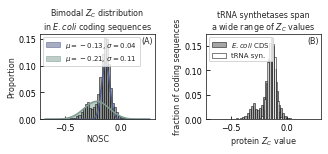

In [15]:
##### Supplementary Fig X --- tRNA synthetase span a wide range of Z_C values

# Load the reference proteomes with NOSC information, subset on E. coli
long_nosc_df = pd.read_csv('../data/genomes/all_ref_prot_NOSC.csv')
coli_nosc_df = long_nosc_df[long_nosc_df.organism == 'coli']
coli_mean_nosc = coli_nosc_df.NOSC.mean()
coli_std_nosc = coli_nosc_df.NOSC.std()

# Fit E. coli NOSC values to a mixture of two gaussians using sklearn
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='diag')
# fit on non-NAN values 
vals = coli_nosc_df.NOSC.values[~np.isnan(coli_nosc_df.NOSC.values)]
gmm.fit(vals.reshape(-1,1))
gmm_means = gmm.means_.flatten()
gmm_stds = np.sqrt(gmm.covariances_).flatten()
gmm_weights = gmm.weights_.flatten()
print (gmm_means, gmm_stds)

mask = bac120_meta_df.Description.str.contains('tRNA ligase')
tRNA_ligases = bac120_meta_df[mask]

# get the ZC values for the tRNA ligases
tRNA_ligase_ZCs = bac120_nosc_df[tRNA_ligases.index].values.flatten()
# print the mean and variance of the ZC values for the tRNA ligases
print (np.nanmean(tRNA_ligase_ZCs), np.nanstd(tRNA_ligase_ZCs))

# plot the histogram of ZC values for the tRNA ligases
fig, axs = plt.subplots(ncols=2, figsize=(4.76, 2.25))
# plot the gaussian mixture model fit to the E. coli NOSC values
# on top of the empirical data 
plt.sca(axs[0])
xs = np.linspace(vals.min(), vals.max(), 100)

# plot the pdf of the two fit gaussians using scipy
from scipy.stats import norm
pal = [colors['dark_blue'], colors['dark_green']]
for i in range(2):
    my_pdf = norm.pdf(xs, gmm_means[i], gmm_stds[i])*gmm_weights[i]
    rescaled_pdf = my_pdf / my_pdf.sum() 
    plt.plot(xs, rescaled_pdf, color=pal[i], lw=1.5)
    # filled plot of the pdf 
    label = '$\mu = {0:.2f}$, $\sigma = {1:.2f}$'.format(gmm_means[i], gmm_stds[i])
    plt.fill_between(xs, rescaled_pdf, color=pal[i], alpha=0.5, label=label)

sns.histplot(data=coli_nosc_df.NOSC, bins=50, color='grey', edgecolor='k',
            linewidth=0.5, alpha=0.7, stat='proportion')
plt.legend(loc=2)
plt.title('Bimodal $Z_C$ distribution\nin $E. coli$ coding sequences')

plt.sca(axs[1])
coli_label = '$E. coli$ CDS'
sns.histplot(data=coli_nosc_df.NOSC, bins=50, color='grey', edgecolor='k',
             linewidth=0.5, alpha=0.7, stat='proportion', label=coli_label)

tRNA_label = 'tRNA syn.'
sns.histplot(data=tRNA_ligase_ZCs, bins=30, color='w', edgecolor='k',
             linewidth=0.5, alpha=0.7, stat='proportion', label=tRNA_label)
plt.xlabel('protein $Z_C$ value')
plt.ylabel('fraction of coding sequences')
plt.title('tRNA synthetases span\na wide range of $Z_C$ values')
plt.legend(loc=2)

# label the panels with text on the top right
panel_labels = 'AB'
for ax, label in zip(axs, panel_labels):
    plt.sca(ax)
    plt.text(0.98, 0.97, '({0})'.format(label), transform=plt.gca().transAxes, fontsize=8,
             va='top', ha='right')

plt.tight_layout()
plt.savefig('../output/FigSX_tRNA_ligase_ZC_hist.png', facecolor='w', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Load the data for the codon substitution analysis
# This is calculated in munge/calc_codon_ZCs.py
codon_subs_mean_df = pd.read_csv('../data/genetic_code/binned_codon_substitutions.csv', index_col=0)


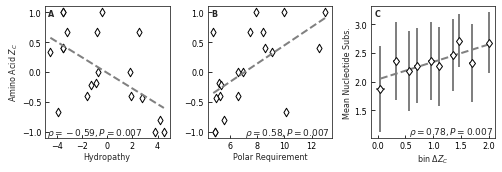

In [14]:
##### Supplementary Fig X -- genetic code is conservative for Z_C.

fig, axs = plt.subplots(ncols=3, figsize=(7.08, 2.5))

plt.sca(axs[0])

mask = np.logical_and(aa_nosc_df.hydropathy.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].hydropathy
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.02, 0.02, '$\\rho = {0:.2f}, P = {1:.1g}$'.format(reg.rvalue, reg.pvalue),
         ha='left', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Hydropathy')
plt.ylabel('Amino Acid $Z_C$')

plt.sca(axs[1])

mask = np.logical_and(aa_nosc_df.polar_requirement.notnull(),
                      aa_nosc_df.NOSC.notnull())
x = aa_nosc_df[mask].polar_requirement
y = aa_nosc_df[mask].NOSC
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.1)
pred_y = reg.slope*pred_xs + reg.intercept

plt.scatter(x, y, marker='d', color='w', edgecolors='k', lw=1)
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.02, '$\\rho = {0:.2f}, P = {1:.1g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('Polar Requirement')

plt.sca(axs[2])
x = codon_subs_mean_df.abs_dNOSC
y = codon_subs_mean_df.hamming_dist
reg = linregress(x, y)

pred_xs = np.arange(x.min(), x.max()*1.01, 0.01)
pred_y = reg.slope*pred_xs + reg.intercept

# hamming distance of codon substitution vs. change in NOSC
# note: symmetric confidence intervals are weird here. can't have > 3 subs
# TODO: consider non-symmetric
plt.errorbar(x, y, xerr=codon_subs_mean_df.abs_dNOSC_std, yerr=codon_subs_mean_df.hamming_dist_std, 
             marker='d', markeredgecolor='k', color='w', ls='', ecolor='grey')
plt.plot(pred_xs, pred_y, marker='', ls='--', color='grey')
plt.text(0.98, 0.03, '$\\rho = {0:.2f}, P = {1:.1g}$'.format(reg.rvalue, reg.pvalue),
         ha='right', fontsize=9, transform=plt.gca().transAxes)
plt.xlabel('bin $\Delta Z_C$')
plt.ylabel('Mean Nucleotide Subs.')

panel_labels = 'ABC'
for ax, label in zip(axs, panel_labels):
    plt.sca(ax)
    plt.text(0.05, 0.98, label, transform=plt.gca().transAxes, fontsize=8,
             va='top', fontweight='bold')

plt.tight_layout()
plt.savefig('../output/FigSX_genetic_code.png', facecolor='w', dpi=300)
plt.show()